In [178]:
import numpy as np
import pandas as pd
from sklearn import tree, neural_network, preprocessing, ensemble, svm, neighbors
import graphviz
from sklearn.model_selection import train_test_split,KFold, ShuffleSplit,RepeatedStratifiedKFold
from sklearn.metrics import *
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import cross_val_score
import time
import warnings


In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(r'fraud_oracle.csv')

In [4]:
df2 = pd.read_csv('motion_data.csv')

In [5]:
variables = list(df.columns)
feature_name = variables.copy()
feature_name.remove('FraudFound_P')

In [6]:
numeric_names = ['WeekOfMonth','WeekOfMonthClaimed','Age','Deductible','DriverRating','Year','PolicyNumber','RepNumber']
convert_names = [ele for ele in feature_name if ele not in numeric_names]

In [7]:
df[convert_names].dtypes

Month                   object
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
Sex                     object
MaritalStatus           object
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
BasePolicy              object
dtype: object

In [8]:
character_converted = pd.DataFrame()
for variable in convert_names:
    character_converted[variable] = preprocessing.LabelEncoder().fit_transform(df[variable])
standard_scaler = preprocessing.StandardScaler()
character_scaled = pd.DataFrame(standard_scaler.fit_transform(character_converted),columns=convert_names)

In [9]:
numeric_raw = df[['WeekOfMonth','WeekOfMonthClaimed','Age','Deductible','DriverRating','Year']].values #returns a numpy array
numeric_scaled = standard_scaler.fit_transform(numeric_raw)
numeric_df = pd.DataFrame(numeric_scaled, columns=['WeekOfMonth','WeekOfMonthClaimed','Age','Deductible','DriverRating','Year'])

In [10]:
X = pd.concat([character_scaled, numeric_df],axis=1)
y = df['FraudFound_P']

In [11]:
fraud_Rate = df['FraudFound_P'].sum()/df['FraudFound_P'].count()

In [12]:
fraud_Rate

0.05985732814526589

In [13]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.3, random_state=1) 

In [14]:
#data processing for driving behavior dataset
numeric_scaled_df2 = standard_scaler.fit_transform(df2[['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']])
X2 = pd.DataFrame(numeric_scaled_df2, columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ'])
y2 = df2['Class'].map({'AGGRESSIVE': 1, 'NORMAL': 0, 'SLOW':0})

X2_Train, X2_Test, y2_Train, y2_Test = train_test_split(X2, y2, test_size=0.3, random_state=1) 

In [15]:
def cross_validation (X_Train,y_Train, group, clf):
    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    for train_index, test_index in group.split(X_Train):
        X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
        Y_train, Y_test = y_Train.iloc[train_index], y_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    
    return test_avg_accu, test_avg_auc, train_avg_accu, train_avg_auc, training_time_sum

# Decision Tree

### Fraud Detection

In [16]:
train_size_depth = list(np.arange(2,9,1)/10)

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []

training_time_series = []

k = 5

for i in range(2,9,1):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10,min_samples_leaf=k)

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    
    for j in range(k):
    
        X_train, X_test, Y_train, Y_test = train_test_split(X_Train, y_Train, test_size=(1-i/10), random_state=1) 
    

        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

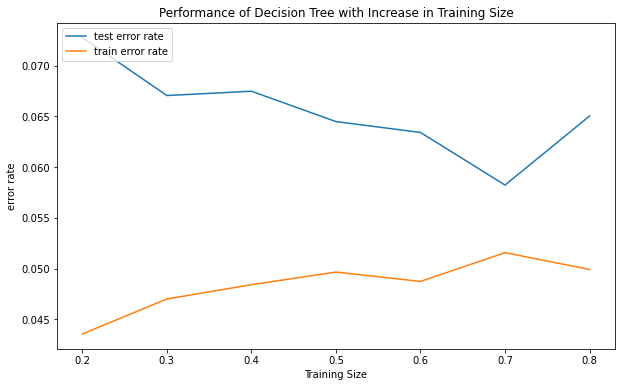

In [17]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_size_depth ,test_accuracy_list, label = "test error rate")
plt.plot(train_size_depth ,train_accuracy_list, label = "train error rate")
plt.legend(loc="upper left")    
plt.title('Performance of Decision Tree with Increase in Training Size')
plt.xlabel('Training Size')
plt.ylabel('error rate')
plt.show()

In [18]:
train_tree_depth = list(np.arange(2,12,1))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(2,12):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i,min_samples_leaf=5)

    test_avg_accu,test_avg_auc,train_avg_accu,train_avg_auc, training_time_sum = cross_validation(X_Train,y_Train, group, clf)
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

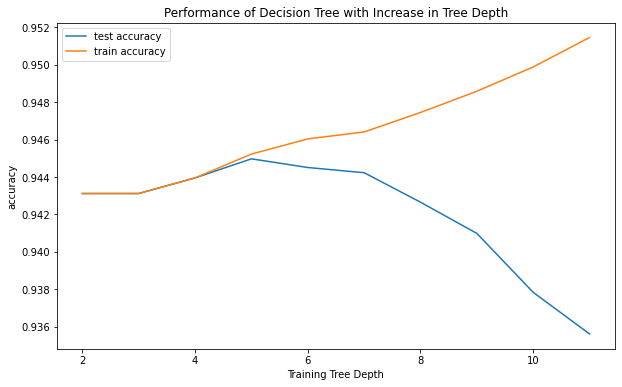

In [19]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_tree_depth ,test_accuracy_list, label = "test accuracy")
plt.plot(train_tree_depth ,train_accuracy_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Decision Tree with Increase in Tree Depth')
plt.xlabel('Training Tree Depth')
plt.ylabel('accuracy')
plt.show()

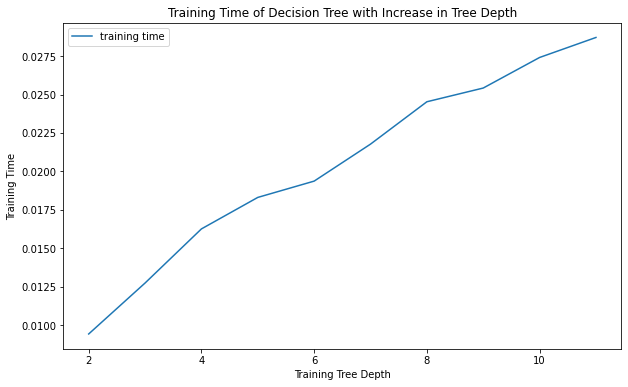

In [20]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_tree_depth ,training_time_series, label = "training time")
plt.legend(loc="upper left")    
plt.title('Training Time of Decision Tree with Increase in Tree Depth')
plt.xlabel('Training Tree Depth')
plt.ylabel('Training Time')
plt.show()

In [21]:
train_tree_depth = list(np.arange(1,12,1))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []


for i in range(1,12,1):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4,min_samples_leaf=i)

    test_avg_accu,test_avg_auc,train_avg_accu,train_avg_auc, training_time_sum = cross_validation(X_Train,y_Train, group, clf)

    test_accuracy_list.append(test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(train_avg_accu)
    train_auc_list.append(train_avg_auc)

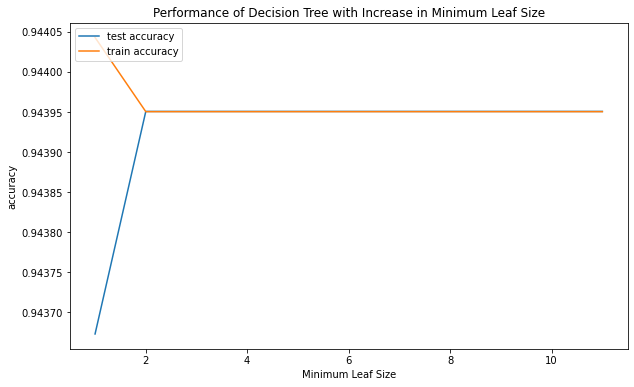

In [22]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_tree_depth ,test_accuracy_list, label = "test accuracy")
plt.plot(train_tree_depth ,train_accuracy_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Decision Tree with Increase in Minimum Leaf Size')
plt.xlabel('Minimum Leaf Size')
plt.ylabel('accuracy')
plt.show()

In [23]:
#retrain the model using the whole training dataset
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4,min_samples_leaf=5)
clf = clf.fit( X_Train,y_Train)
y_Pred = clf.predict(X_Test)
tree_accuracy = accuracy_score(y_Test , y_Pred)
tree_auc = roc_auc_score(y_Test , y_Pred)

In [24]:
tree_accuracy

0.9332036316472114

In [25]:
tree_auc

0.5150230180523602

In [26]:
cm=confusion_matrix(y_Test , y_Pred)
cm

array([[4307,   10],
       [ 299,   10]], dtype=int64)

### Driving Behavior Detection

In [27]:
train_size_depth = list(np.arange(2,9,1)/10)

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []

training_time_series = []
for i in range(2,9,1):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=7,min_samples_leaf=10)

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    
    for j in range(5):
    
        X_train, X_test, Y_train, Y_test = train_test_split(X2_Train, y2_Train, test_size=(1-i/10), random_state=1) 
    

        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

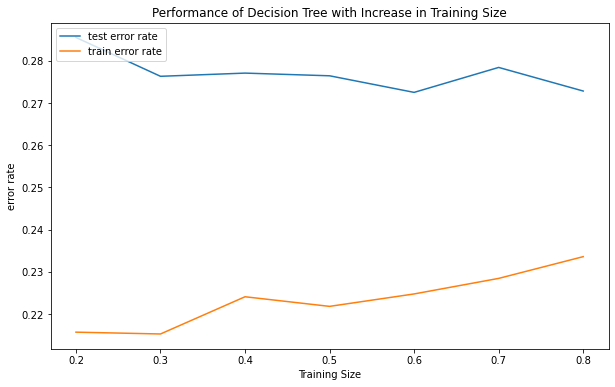

In [28]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_size_depth ,test_accuracy_list, label = "test error rate")
plt.plot(train_size_depth ,train_accuracy_list, label = "train error rate")
plt.legend(loc="upper left")    
plt.title('Performance of Decision Tree with Increase in Training Size')
plt.xlabel('Training Size')
plt.ylabel('error rate')
plt.show()

In [29]:
train_tree_depth = list(np.arange(2,12,1))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(2,12):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i,min_samples_leaf=5)

    test_avg_accu,test_avg_auc,train_avg_accu,train_avg_auc, training_time_sum = cross_validation(X2_Train,y2_Train, group, clf)
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

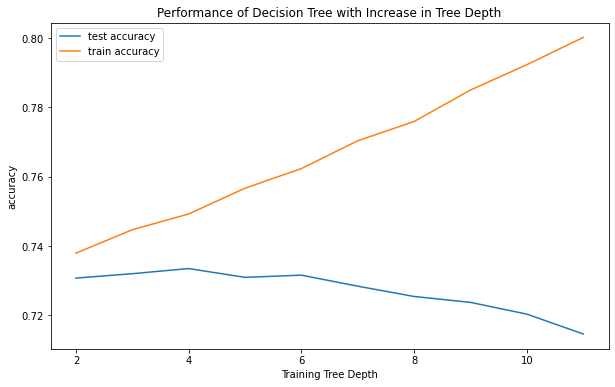

In [30]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_tree_depth ,test_accuracy_list, label = "test accuracy")
plt.plot(train_tree_depth ,train_accuracy_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Decision Tree with Increase in Tree Depth')
plt.xlabel('Training Tree Depth')
plt.ylabel('accuracy')
plt.show()

In [126]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i,min_samples_leaf=5)
clf = clf.fit( X2_Train,y2_Train)
y_Pred = clf.predict(X2_Test)

In [128]:
cm=confusion_matrix(y2_Test , y_Pred)
cm

array([[1088,  341],
       [ 364,  226]], dtype=int64)

In [129]:
tree_auc = roc_auc_score(y2_Test , y_Pred)
tree_auc

0.5722112179905351

# Neural networks

#### Fraud Detection

In [ ]:
max_iteration = list(np.arange(10,160,10))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
iteration_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(10,160,10):
    clf = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,),solver= 'adam', activation='relu', max_iter=i)

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    iteration_sum = 0
    for train_index, test_index in group.split(X_Train):
        X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
        Y_train, Y_test = y_Train.iloc[train_index], y_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        iteration_sum += clf.n_iter_
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)
    iteration_list.append(iteration_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

In [ ]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_auc_list, label = "test accuracy")
plt.plot(max_iteration ,train_auc_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Neural Network with Increase in Maximum Iteration')
plt.xlabel('Maximum Iteration')
plt.ylabel('accuracy')
plt.show()

In [ ]:

plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,training_time_series, label = "training time")
plt.legend(loc="upper left")    
plt.title('Training Time of Neural Network with Increase in Maximum Iteration')
plt.xlabel('Training Tree Depth')
plt.ylabel('Training Time')
plt.show()

In [ ]:
clf = neural_network.MLPClassifier(hidden_layer_sizes=(200,100,),solver= 'adam', activation='relu')
clf = clf.fit( X_Train,y_Train)
Y2_pred_train = clf.predict(X_Train)

In [ ]:
Y2_pred_train.sum()

In [ ]:
y_Train.sum()

In [ ]:
clf.n_iter_

In [ ]:
clf = neural_network.MLPClassifier(hidden_layer_sizes=(100,100), activation='relu',max_iter=1000)
clf = clf.fit(X2_Train,y2_Train)
Y_pred_train = clf.predict(X2_Train)

#### Driving Behavior Detection

In [ ]:
max_iteration = list(np.arange(10,250,10))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
iteration_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(10,250,10):
    clf = neural_network.MLPClassifier(hidden_layer_sizes=(60,30,15,),solver= 'adam', activation='relu', max_iter=i)

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    iteration_sum = 0
    for train_index, test_index in group.split(X2_Train):
        X_train, X_test = X2_Train.iloc[train_index], X2_Train.iloc[test_index]
        Y_train, Y_test = y2_Train.iloc[train_index], y2_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        iteration_sum += clf.n_iter_
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)
    iteration_list.append(iteration_sum/k)

    test_accuracy_list.append(test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(train_avg_accu)
    train_auc_list.append(train_avg_auc)

In [ ]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_accuracy_list, label = "test accuracy")
plt.plot(max_iteration ,train_accuracy_list, label = "train accuracy")
plt.legend(loc="upper left")    
plt.title('Performance of Neural Network with Increase in Maximum Iteration')
plt.xlabel('Maximum Iteration')
plt.ylabel('accuracy')
plt.show()

In [ ]:

plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,training_time_series, label = "training time")
plt.legend(loc="upper left")    
plt.title('Training Time of Neural Network with Increase in Maximum Iteration')
plt.xlabel('Training Tree Depth')
plt.ylabel('Training Time')
plt.show()

## Boosting

#### Fraud Detection Problem

In [85]:
max_iteration = list(np.arange(20,350,20))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
iteration_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []

for i in range(20,350,20):
    clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = i,min_samples_leaf = 1,max_depth = 3,random_state = 1, max_features=10)

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    iteration_sum = 0
    for train_index, test_index in group.split(X_Train):
        X_train, X_test = X_Train.iloc[train_index], X_Train.iloc[test_index]
        Y_train, Y_test = y_Train.iloc[train_index], y_Train.iloc[test_index]
        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)
        

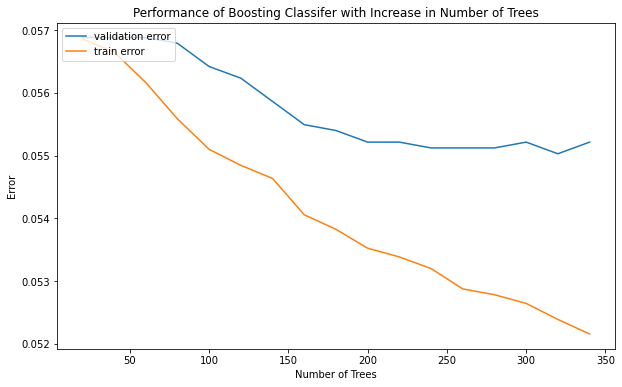

In [86]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_accuracy_list, label = "validation error")
plt.plot(max_iteration ,train_accuracy_list, label = "train error")
plt.legend(loc="upper left")    
plt.title('Performance of Boosting Classifer with Increase in Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.show()

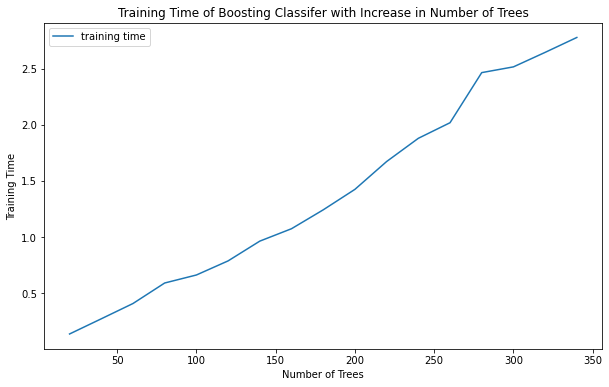

In [87]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,training_time_series, label = "training time")
plt.legend(loc="upper left")    
plt.title('Training Time of Boosting Classifer with Increase in Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Training Time')
plt.show()

In [112]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 250,min_samples_leaf = 1,max_depth = 5,random_state = 1, max_features=10)
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)

In [113]:
np.mean(n_scores)

0.9437651557525216

In [114]:
clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 250,min_samples_leaf = 1,max_depth = 3,random_state = 1, max_features=10)
clf = clf.fit( X_Train,y_Train)
y_Pred = clf.predict(X_Test)

In [115]:
cm=confusion_matrix(y_Test , y_Pred)
cm

array([[4315,    2],
       [ 301,    8]], dtype=int64)

#### Driving Behavior Detection

In [118]:
max_iteration = list(np.arange(10,110,10))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(10,110,10):
    clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = i,min_samples_leaf = 1,max_depth = 3,random_state = 1, max_features=3)

    test_avg_accu,test_avg_auc,train_avg_accu,train_avg_auc, training_time_sum = cross_validation(X2_Train,y2_Train, group, clf)
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)

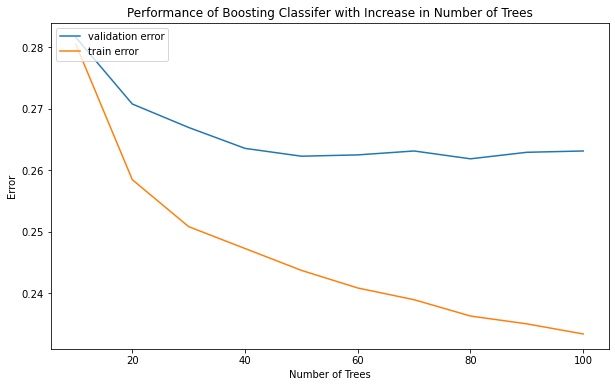

In [119]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_accuracy_list, label = "validation error")
plt.plot(max_iteration ,train_accuracy_list, label = "train error")
plt.legend(loc="upper left")    
plt.title('Performance of Boosting Classifer with Increase in Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.show()

In [121]:
clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 80,min_samples_leaf = 1,max_depth = 3,random_state = 1, max_features=3)
n_scores = cross_val_score(clf, X2_Train,y2_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.7370999365990464

In [123]:
clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 80,min_samples_leaf = 1,max_depth = 3,random_state = 1, max_features=5)
n_scores = cross_val_score(clf, X2_Train,y2_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.7345503608890572

In [124]:
clf = ensemble.GradientBoostingClassifier(learning_rate = 0.05, n_estimators = 80,min_samples_leaf = 1,max_depth = 3,random_state = 1, max_features=5)
clf = clf.fit( X2_Train,y2_Train)
y_Pred = clf.predict(X2_Test)

In [125]:
cm=confusion_matrix(y2_Test , y_Pred)
cm

array([[1376,   53],
       [ 481,  109]], dtype=int64)

## SVM

#### Fraud Detection Problem

In [140]:
clf = svm.SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=-1, decision_function_shape='ovr')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.943116578617173

In [132]:
clf = svm.SVC(C=1.0, kernel='poly', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=-1, decision_function_shape='ovr')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9412637831763153

In [133]:
clf = svm.SVC(C=1.0, kernel='poly', degree=5, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=-1, decision_function_shape='ovr')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9383918686825543

In [134]:
clf = svm.SVC(C=1.0, kernel='sigmoid', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=-1, decision_function_shape='ovr')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9181025094427662

In [159]:
max_iteration = list(np.arange(50,700,50))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(50,700,50):
    clf = svm.SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=i, decision_function_shape='ovr')

    test_avg_accu,test_avg_auc,train_avg_accu,train_avg_auc, training_time_sum = cross_validation(X_Train,y_Train, group, clf)
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)

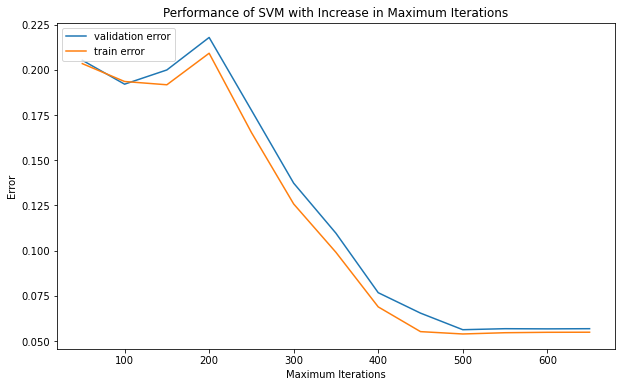

In [160]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_accuracy_list, label = "validation error")
plt.plot(max_iteration ,train_accuracy_list, label = "train error")
plt.legend(loc="upper left")    
plt.title('Performance of SVM with Increase in Maximum Iterations')
plt.xlabel('Maximum Iterations')
plt.ylabel('Error')
plt.show()

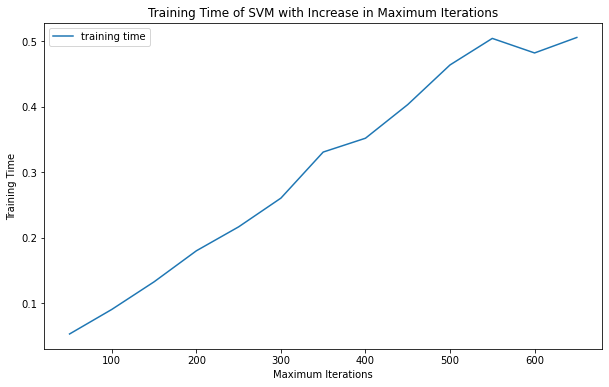

In [167]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,training_time_series, label = "training time")
plt.legend(loc="upper left")    
plt.title('Training Time of SVM with Increase in Maximum Iterations')
plt.xlabel('Maximum Iterations')
plt.ylabel('Training Time')
plt.show()

In [168]:
clf = svm.SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=i, decision_function_shape='ovr')
clf = clf.fit( X_Train,y_Train)
y_Pred = clf.predict(X_Test)

In [169]:
cm=confusion_matrix(y_Test , y_Pred)
cm

array([[4317,    0],
       [ 307,    2]], dtype=int64)

#### Driving Behavior Detection

In [174]:
max_iteration = list(np.arange(100,1200,100))

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []
k=5
group = KFold(n_splits=k, random_state=1,shuffle=True)
training_time_series = []
for i in range(100,1200,100):
    clf = svm.SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, max_iter=i, decision_function_shape='ovr')
    
    test_avg_accu,test_avg_auc,train_avg_accu,train_avg_auc, training_time_sum = cross_validation(X2_Train,y2_Train, group, clf)
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)

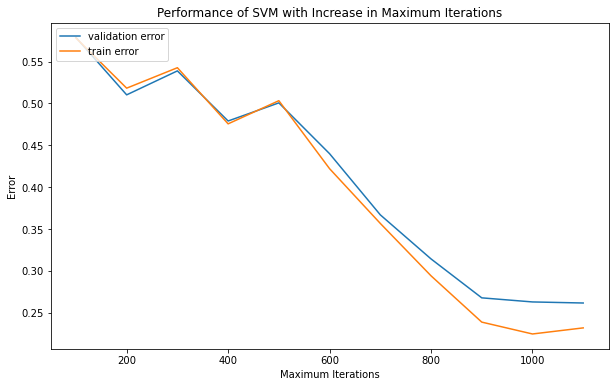

In [175]:
plt.figure(figsize=(10, 6)) 
plt.plot(max_iteration ,test_accuracy_list, label = "validation error")
plt.plot(max_iteration ,train_accuracy_list, label = "train error")
plt.legend(loc="upper left")    
plt.title('Performance of SVM with Increase in Maximum Iterations')
plt.xlabel('Maximum Iterations')
plt.ylabel('Error')
plt.show()

In [176]:
clf = svm.SVC(C=1.0, kernel='rbf', gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, decision_function_shape='ovr')
clf = clf.fit( X2_Train,y2_Train)
y_Pred = clf.predict(X2_Test)

In [177]:
cm=confusion_matrix(y2_Test , y_Pred)
cm

array([[1389,   40],
       [ 508,   82]], dtype=int64)

## KNN

#### fraud detection

In [179]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9410784692909951

In [187]:
clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9437650698994361

In [188]:
clf = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9434871634612702

In [180]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
n_scores = cross_val_score(clf, X_Train,y_Train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9409858338116066

In [185]:
train_size_depth = list(np.arange(2,9,1)/10)

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []

training_time_series = []

k = 5

for i in range(2,9,1):
    clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', leaf_size=30, p=2, metric='minkowski')

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    
    for j in range(k):
    
        X_train, X_test, Y_train, Y_test = train_test_split(X_Train, y_Train, test_size=(1-i/10), random_state=1) 
    

        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)

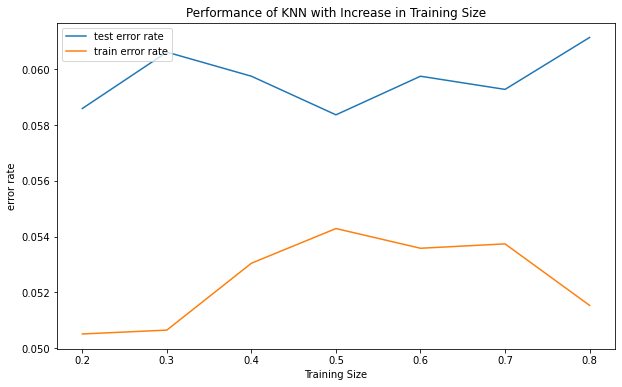

In [186]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_size_depth ,test_accuracy_list, label = "test error rate")
plt.plot(train_size_depth ,train_accuracy_list, label = "train error rate")
plt.legend(loc="upper left")    
plt.title('Performance of KNN with Increase in Training Size')
plt.xlabel('Training Size')
plt.ylabel('error rate')
plt.show()

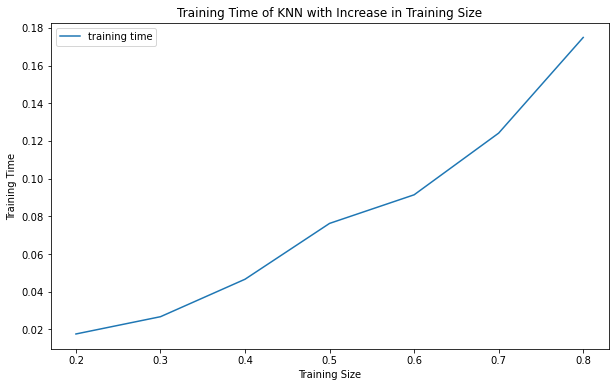

In [189]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_size_depth ,training_time_series, label = "training time")
plt.legend(loc="upper left")    
plt.title('Training Time of KNN with Increase in Training Size')
plt.xlabel('Training Size')
plt.ylabel('Training Time')
plt.show()

#### Driving Behavior Detection

In [212]:
train_size_depth = list(np.arange(2,9,1)/10)

test_accuracy_list = []
test_auc_list = []
train_accuracy_list = []
train_auc_list = []

training_time_series = []

k = 5

for i in range(2,9,1):
    clf = neighbors.KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='kd_tree', leaf_size=5, p=2, metric='minkowski')

    test_agg_accu = 0
    test_agg_auc = 0
    train_agg_accu = 0
    train_agg_auc = 0
    training_time_sum = 0
    
    for j in range(k):
    
        X_train, X_test, Y_train, Y_test = train_test_split(X2_Train, y2_Train, test_size=(1-i/10), random_state=1) 
    

        start = time.time()
        clf = clf.fit( X_train,Y_train)
        stop = time.time()
        training_time = stop - start
        training_time_sum += training_time
        Y_pred = clf.predict(X_test)
        Y_pred_train = clf.predict(X_train)
        test_accuracy = accuracy_score(Y_test , Y_pred)
        test_auc = roc_auc_score(Y_test , Y_pred)
        train_accuracy = accuracy_score(Y_train , Y_pred_train)
        train_auc = roc_auc_score(Y_train , Y_pred_train)
        test_agg_accu = test_agg_accu+ test_accuracy
        test_agg_auc = test_agg_auc + test_auc
        train_agg_accu = train_agg_accu + train_accuracy
        train_agg_auc = train_agg_auc + train_auc
    test_avg_accu = test_agg_accu/k
    test_avg_auc = test_agg_auc/k
    train_avg_accu = train_agg_accu/k
    train_avg_auc = train_agg_auc/k
    training_time_series.append(training_time_sum/k)

    test_accuracy_list.append(1-test_avg_accu)
    test_auc_list.append(test_avg_auc)

    train_accuracy_list.append(1-train_avg_accu)
    train_auc_list.append(train_avg_auc)

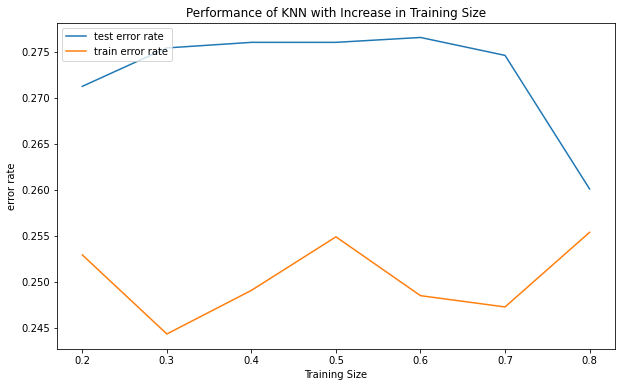

In [213]:
plt.figure(figsize=(10, 6)) 
plt.plot(train_size_depth ,test_accuracy_list, label = "test error rate")
plt.plot(train_size_depth ,train_accuracy_list, label = "train error rate")
plt.legend(loc="upper left")    
plt.title('Performance of KNN with Increase in Training Size')
plt.xlabel('Training Size')
plt.ylabel('error rate')
plt.show()

In [201]:
sum(y2_Train)/len(y2_Train)

0.28392440008494374